### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра математического моделирования и искусственного интеллекта

## ОТЧЕТ ПО КОНТРОЛЬНОЙ РАБОТЕ № 5


### Дисциплина: Методы машинного обучения

##### Студент:  Абдуллина Ляйсан Раисовна
##### Группа:   НПИ-01-21

## Москва 2024
***

### Вариант № 21

1. Набор данных deep_weeds, imagenette/160px-v2

2. Классы с метками 1,2,3

3. Требования к архитектуре сети MLP:

Кол-во скрытых слоев 4

Кол-во нейронов 100 в первом скрытом слое, уменьшающееся на 20 с каждым последующим скрытым слоем

Оптимизатор AdamW

Функция активации в скрытых слоях leaky_relu

Слои dropout после каждого скрытого слоя

4. Требования к архитектуре сети CNN:

Кол-во слоев пулинга 4

Количество фильтров в сверточных слоях 8

Размеры фильтра 5х5

Оптимизатор Adafactor

Функция активации в сверточных слоях relu

Функция активации в скрытых плотных слоях tanh

Слои dropout после каждого слоя пулинга

5. Показатель качества бинарной классификации:

индекс Фоулкса – Мэллоуса, равный корню квадратному из TP/(TP + TN) * TP/(TP + FP)

6. Показатель качества многоклассовой классификации:

средняя точность классов, где точность (precision) класса равна доле правильных предсказаний для всех точек, относимых классификатором к этому классу.

***



Загрузим все необходиме библиотеки

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds

from PIL import Image, ImageOps
import random
from sklearn.metrics import matthews_corrcoef
import tensorflow.keras.backend as K
from sklearn.metrics import roc_curve, auc

1. Загрузите заданный в индивидуальном задании набор данных с изображениями из Tensorflow Datasets с разбиением на обучающую и тестовую выборки.


In [3]:
ds = tfds.load("imagenette/160px-v2", split=['train', 'validation'])
df_train = tfds.as_dataframe(ds[0])
df_test  = tfds.as_dataframe(ds[1])
df_train.shape, df_test.shape

((9469, 2), (3925, 2))

In [4]:
df_train.iloc[0]['image'].shape

(160, 198, 3)

In [5]:
df_train.iloc[1]['image'].shape

(160, 213, 3)

Как можно заметить выше, в нашем датасете встерчаются картинки разных размеров. Поэтому приведем их к одному размеру (и сделаем меньше, потому что колаб не может выдеражать)

In [6]:
train_labels = df_train['label'].to_numpy(dtype=np.float32)
test_labels = df_test['label'].to_numpy(dtype=np.float32)
train_labels.shape, test_labels.shape

((9469,), (3925,))

Это было сделано, поскольку при попытке обучения нейросети колаб просто вылетал

In [7]:
# Создание массивов для изображений с уменьшенным размером
image_height, image_width = 100, 100  # уменьшаем размер изображений
train_images = np.zeros(shape=(df_train.shape[0], image_height, image_width, 3), dtype=np.float32)
test_images  = np.zeros(shape=(df_test.shape[0], image_height, image_width, 3), dtype=np.float32)

In [8]:
# Изменение размера изображений и сохранение в массивы
for idx in range(train_labels.shape[0]):
    img = Image.fromarray(df_train.iloc[idx]['image'])
    img_resized = img.resize((image_width, image_height))
    train_images[idx, :, :, :] = np.array(img_resized)

for idx in range(test_labels.shape[0]):
    img = Image.fromarray(df_test.iloc[idx]['image'])
    img_resized = img.resize((image_width, image_height))
    test_images[idx, :, :, :] = np.array(img_resized)

In [9]:
train_images.shape, test_images.shape

((9469, 100, 100, 3), (3925, 100, 100, 3))

In [10]:
train_images /= 255
test_images  /= 255

2. Визуализируйте несколько изображений, отобранных случайным образом из обучающей выборки.

In [11]:
def plot_random_sample(images):
    n = 10
    imgs = random.sample(list(images), n)

    num_row = 2
    num_col = 5

    fig, axes = plt.subplots(num_row, num_col, figsize=(3.5 * num_col, 3 * num_row))
    # For every image
    for i in range(num_row * num_col):
        # Read the image
        img = imgs[i]
        # Display the image
        ax = axes[i // num_col, i % num_col]
        ax.imshow(img)

    plt.tight_layout()
    plt.show()

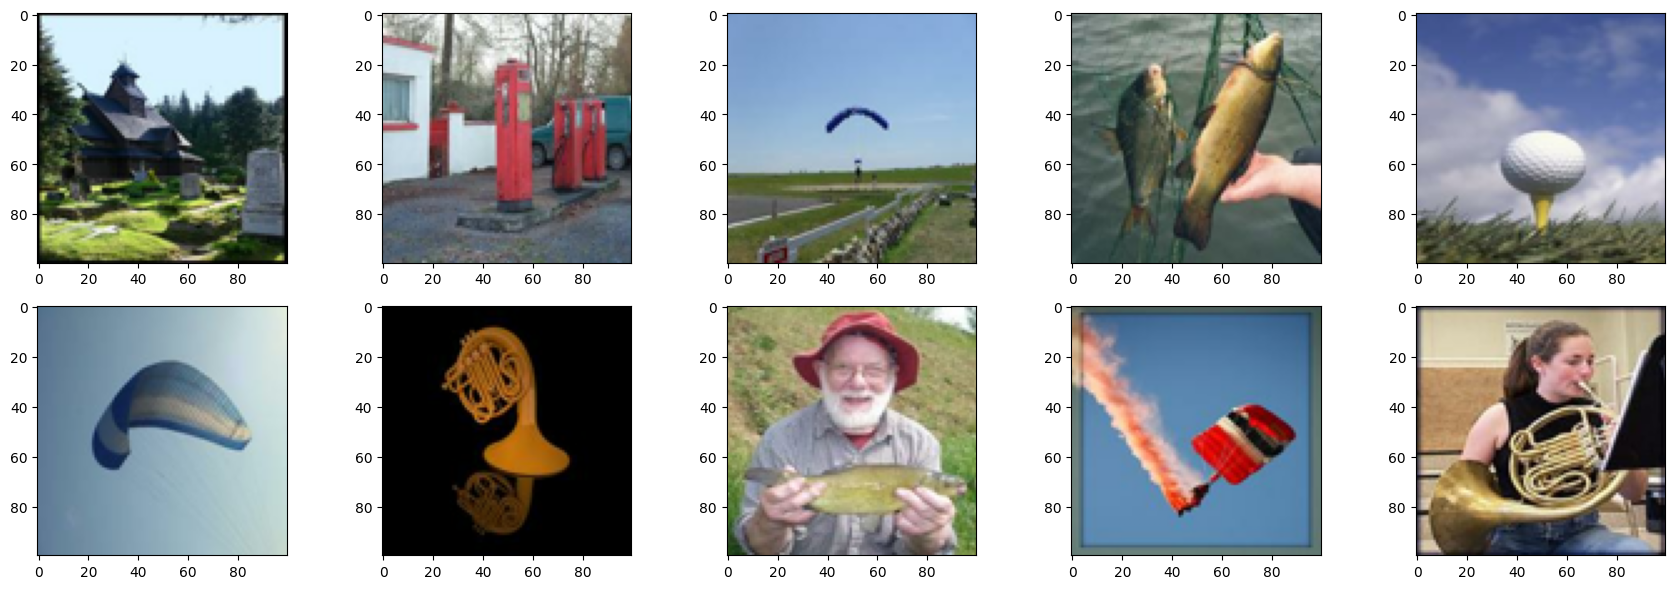

In [12]:
plot_random_sample(test_images)

3. Оставьте в наборе изображения двух классов, указанных в индивидуальном задании первыми(1,2). Обучите нейронные сети MLP и CNN задаче бинарной классификации изображений (требования к архитектуре сетей указаны в индивидуальном задании). Отследите обучение нейронных сетей и укажите, на сколько процентов снизились в результате обучения потери по отношению к потерям на первой эпохе обучения. Оцените результаты обучения нейронных сетей (варианты: нейронная сеть обучилась, недообучилась, переобучилась).

Кол-во скрытых слоев 4

Кол-во нейронов 100 в первом скрытом слое, уменьшающееся на 20 с каждым последующим скрытым слоем

Оптимизатор AdamW

Функция активации в скрытых слоях leaky_relu

Слои dropout после каждого скрытого слоя

In [13]:
# Фильтрация данных для классов 1 и 2
train_indices = np.isin(train_labels, [1, 2])
test_indices = np.isin(test_labels, [1, 2])

train_images_binary = train_images[train_indices]
test_images_binary = test_images[test_indices]
train_labels_binary = train_labels[train_indices]
test_labels_binary = test_labels[test_indices]

# Преобразование меток в бинарный формат
train_labels_binary = np.where(train_labels_binary == 1, 0, 1)
test_labels_binary = np.where(test_labels_binary == 1, 0, 1)


Вычисление показателя качества бинарной классификации: индекс Фоулкса – Мэллоуса, равный корню квадратному из TP/(TP + TN) * TP/(TP + FP)

In [14]:
def mcc_metric(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn) + K.epsilon())

    return numerator / (denominator + K.epsilon())

# Нейронная сеть MLP

In [15]:
tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(image_height, image_width, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(80, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(60, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(40, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')

])


In [16]:
model_1.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.AdamW(),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'), mcc_metric]
)

history_1 = model_1.fit(
    train_images_binary,
    train_labels_binary,
    epochs=25,
    batch_size=32,
    validation_data=(test_images_binary, test_labels_binary)
)

Epoch 1/25
61/61 [==============================] - 8s 82ms/step - loss: 1.6152 - accuracy: 0.5349 - mcc_metric: 0.0662 - val_loss: 0.6513 - val_accuracy: 0.6941 - val_mcc_metric: 0.3755
Epoch 2/25
61/61 [==============================] - 4s 63ms/step - loss: 0.7653 - accuracy: 0.5529 - mcc_metric: 0.1059 - val_loss: 0.6639 - val_accuracy: 0.6316 - val_mcc_metric: 0.3549
Epoch 3/25
61/61 [==============================] - 5s 75ms/step - loss: 0.6863 - accuracy: 0.5945 - mcc_metric: 0.1958 - val_loss: 0.5444 - val_accuracy: 0.7141 - val_mcc_metric: 0.4167
Epoch 4/25
61/61 [==============================] - 4s 57ms/step - loss: 0.6392 - accuracy: 0.6366 - mcc_metric: 0.2723 - val_loss: 0.5521 - val_accuracy: 0.7021 - val_mcc_metric: 0.3911
Epoch 5/25
61/61 [==============================] - 4s 62ms/step - loss: 0.6406 - accuracy: 0.6463 - mcc_metric: 0.3008 - val_loss: 0.5659 - val_accuracy: 0.7221 - val_mcc_metric: 0.4399
Epoch 6/25
61/61 [==============================] - 5s 75ms/step 

In [17]:
# Оценка результатов обучения
loss_reduction = (history_1.history['loss'][0] - history_1.history['loss'][-1]) / history_1.history['loss'][0] * 100
print(f"Потери снизились на {loss_reduction:.2f}%.")

Потери снизились на 69.30%.


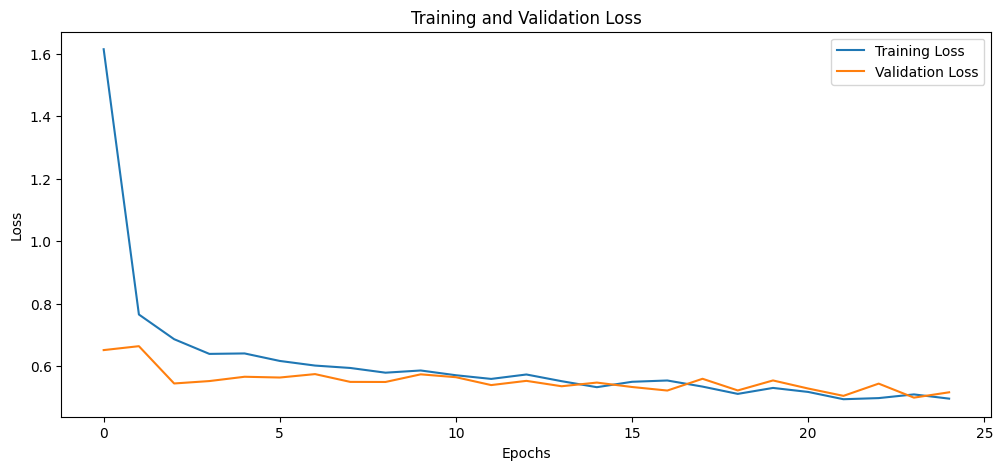

In [18]:
# График потерь
plt.figure(figsize=(12, 5))

plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
# Оценка результатов обучения
train_loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

if val_loss[-1] < train_loss[-1]:
    print("Модель недообучилась.")
elif val_loss[-1] > train_loss[-1] and (val_loss[-1] - train_loss[-1]) / val_loss[-1] > 0.1:
    print("Модель переобучилась")
else:
    print("Модель нормально обучилась.")

Модель нормально обучилась.


# Нейронная сеть CNN

Требования к архитектуре сети CNN:

Кол-во слоев пулинга 4

Количество фильтров в сверточных слоях 8

Размеры фильтра 5х5

Оптимизатор Adafactor

Функция активации в сверточных слоях relu

Функция активации в скрытых плотных слоях tanh

Слои dropout после каждого слоя пулинга

In [20]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(8, (5, 5), activation='relu', input_shape=(image_height, image_width, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(8, (2, 2), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(8, (2, 2), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(8, (2, 2), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(8, (2, 2), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])



In [21]:
model_2.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adafactor(),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'), mcc_metric
    ]
)

history_2 = model_2.fit(
    train_images_binary,
    train_labels_binary,
    epochs=50,
    batch_size=32,
    validation_data=(test_images_binary, test_labels_binary)
)

Epoch 1/50
61/61 [==============================] - 16s 230ms/step - loss: 0.7059 - accuracy: 0.5072 - mcc_metric: -0.0021 - val_loss: 0.6941 - val_accuracy: 0.4668 - val_mcc_metric: -0.0407
Epoch 2/50
61/61 [==============================] - 14s 226ms/step - loss: 0.6931 - accuracy: 0.5252 - mcc_metric: 0.0517 - val_loss: 0.6936 - val_accuracy: 0.4734 - val_mcc_metric: -0.0100
Epoch 3/50
61/61 [==============================] - 14s 228ms/step - loss: 0.6908 - accuracy: 0.5241 - mcc_metric: 0.0473 - val_loss: 0.6932 - val_accuracy: 0.4761 - val_mcc_metric: 0.0062
Epoch 4/50
61/61 [==============================] - 14s 222ms/step - loss: 0.6895 - accuracy: 0.5190 - mcc_metric: 0.0438 - val_loss: 0.6927 - val_accuracy: 0.4734 - val_mcc_metric: -0.0133
Epoch 5/50
61/61 [==============================] - 13s 221ms/step - loss: 0.6848 - accuracy: 0.5400 - mcc_metric: 0.0823 - val_loss: 0.6921 - val_accuracy: 0.4734 - val_mcc_metric: -0.0026
Epoch 6/50
61/61 [==============================] 

In [22]:
# Оценка результатов обучения
loss_reduction = (history_2.history['loss'][0] - history_2.history['loss'][-1]) / history_2.history['loss'][0] * 100
print(f"Потери снизились на {loss_reduction:.2f}%.")

Потери снизились на 31.01%.


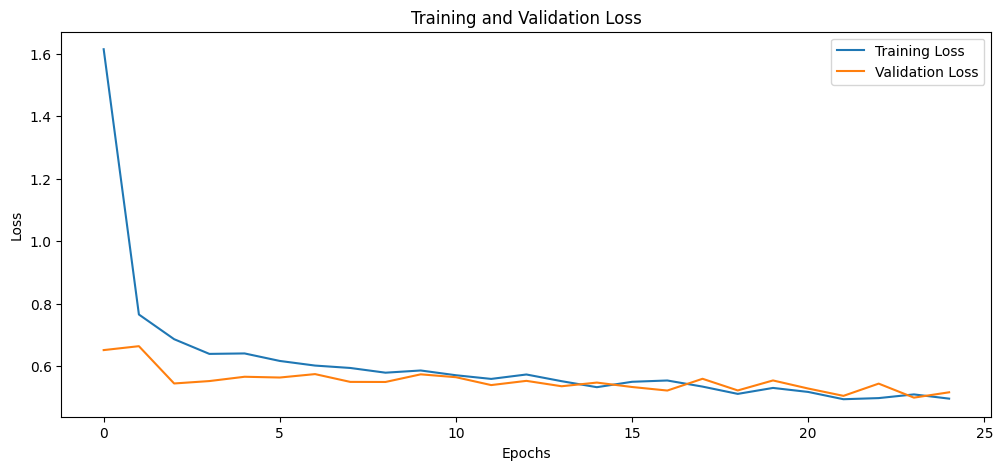

In [23]:
# График потерь
plt.figure(figsize=(12, 5))
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
train_loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

if val_loss[-1] < train_loss[-1]:
    print("Модель недообучилась.")
elif val_loss[-1] > train_loss[-1] and (val_loss[-1] - train_loss[-1]) / val_loss[-1] > 0.1:
    print("Модель переобучилась")
else:
    print("Модель нормально обучилась.")

Модель недообучилась.


4. Постройте кривые обучения нейронных сетей бинарной классификации для показателей потерь и доли верных ответов в зависимости от эпохи обучения, подписывая оси и рисунок и создавая легенду.

In [25]:
def learn_graphic(history, metric='accuracy'):
    plt.figure(figsize=(12, 5))

    # Получение значений метрики для обучающей и проверочной выборок
    train_metric = history.history[metric]
    val_metric = history.history[f'val_{metric}']

    # Построение кривых обучения
    epochs = range(1, len(train_metric) + 1)
    plt.plot(epochs, train_metric, 'b', label=f'Training {metric}')
    plt.plot(epochs, val_metric, 'r', label=f'Validation {metric}')
    if history == history_1:
        plt.title(f'MLP: {metric} per Epoch')
    else:
        plt.title(f'CNN: {metric} per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()


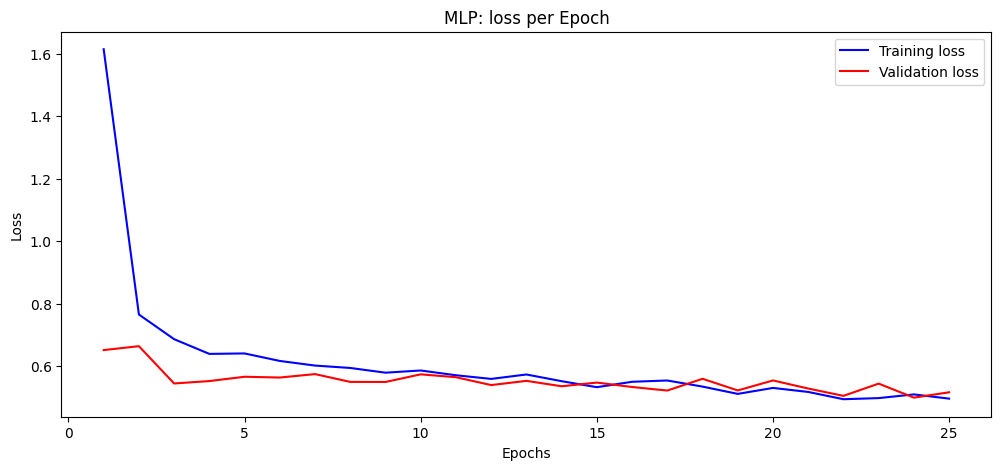

In [26]:
learn_graphic(history_1, metric='loss')

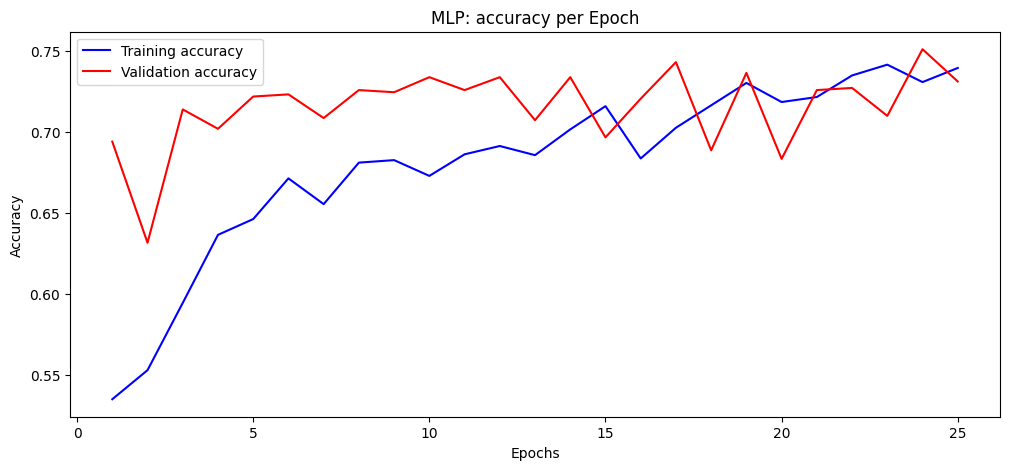

In [27]:
learn_graphic(history_1, metric='accuracy')

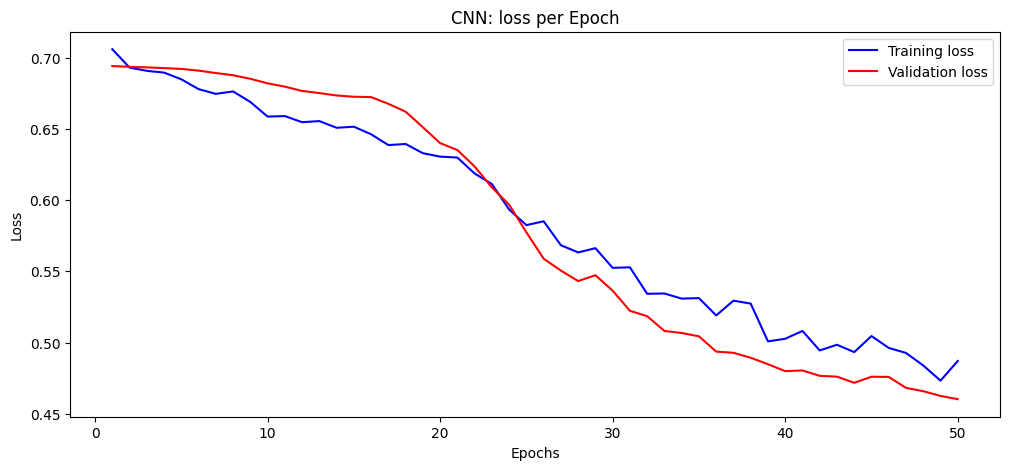

In [28]:
learn_graphic(history_2, metric='loss')

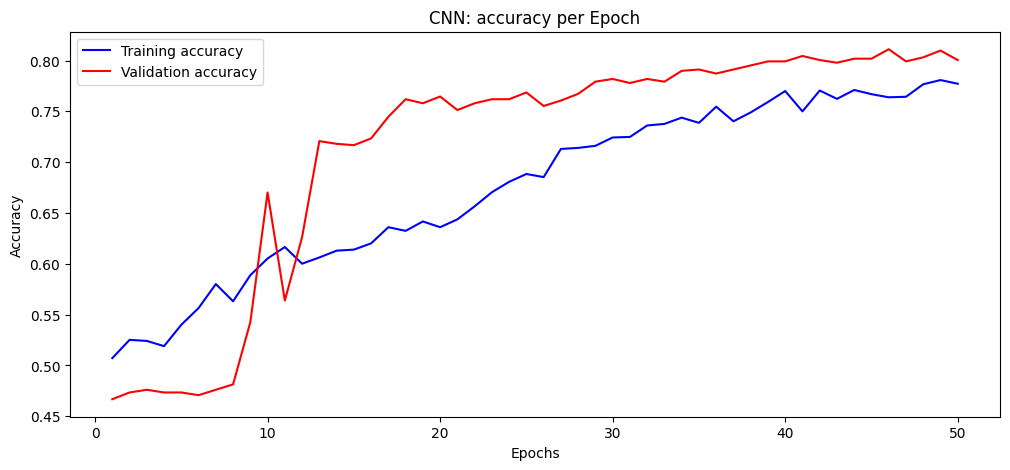

In [29]:
learn_graphic(history_2, metric='accuracy')

5. Сравните качество бинарной классификации нейронными сетями при помощи показателя качества, указанного в индивидуальном задании.

Еще раз создаю ф-цию для вычисления индекса, потому что та не очень удобная для этого задания

In [30]:
def calculate_mcc_score(predictions, test_labels):
    mcc = matthews_corrcoef(test_labels, predictions)
    return mcc

# Вычисляем MCC для первой модели
predictions_1 = (model_1.predict(test_images_binary) > 0.5).astype(int)
mcc_1 = calculate_mcc_score(predictions_1, test_labels_binary)

# Вычисляем MCC для второй модели
predictions_2 = (model_2.predict(test_images_binary) > 0.5).astype(int)
mcc_2 = calculate_mcc_score(predictions_2, test_labels_binary)

print("MCC для первой модели:", mcc_1)
print("MCC для второй модели:", mcc_2)

# Сравниваем результаты
if mcc_1 > mcc_2:
    print("Первая модель показывает лучший результат.")
elif mcc_1 < mcc_2:
    print("Вторая модель показывает лучший результат.")
else:
    print("Модели показывают одинаковое качество.")


24/24 [==============================] - 2s 88ms/step
MCC для первой модели: 0.46061458783451986
MCC для второй модели: 0.6088014159339775
Вторая модель показывает лучший результат.


6. Визуализируйте ROC-кривые для построенных классификаторов на одном рисунке (с легендой) и вычислите площади под ROC-кривыми.

24/24 [==============================] - 1s 51ms/step
Площадь для модели 1 (MLP): 0.8320391447718329
Площадь для модели 2(CNN): 0.8812112186646811


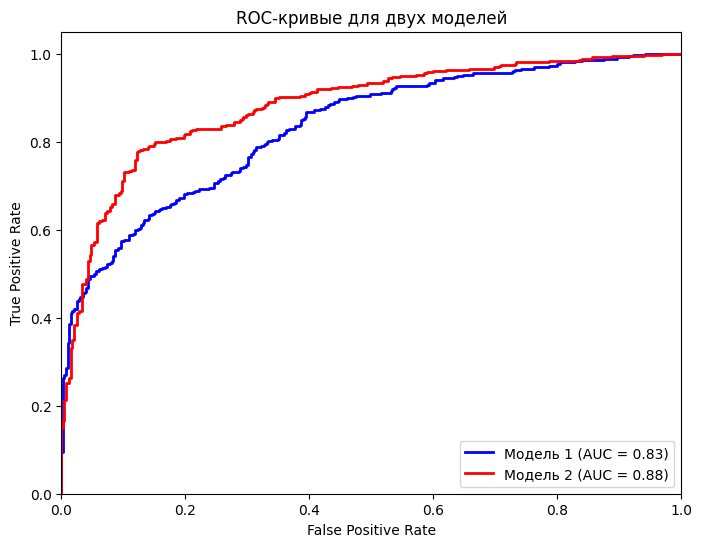

In [31]:
fpr_1, tpr_1, _ = roc_curve(test_labels_binary, model_1.predict(test_images_binary))
auc_1 = auc(fpr_1, tpr_1)

fpr_2, tpr_2, _ = roc_curve(test_labels_binary, model_2.predict(test_images_binary))
auc_2 = auc(fpr_2, tpr_2)

plt.figure(figsize=(8, 6))
plt.plot(fpr_1, tpr_1, color='blue', lw=2, label=f'Модель 1 (AUC = {auc_1:.2f})')
plt.plot(fpr_2, tpr_2, color='red', lw=2, label=f'Модель 2 (AUC = {auc_2:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для двух моделей')
plt.legend(loc='lower right')

print("Площадь для модели 1 (MLP):", auc_1)
print("Площадь для модели 2(CNN):", auc_2)

plt.show()


## ДАЛЕЕ ВО ВТОРОЙ ЧАСТИ - ОЗУ НЕ ХВАТИЛО